#### Regular DBScan is amazing at clustering data of varying shapes, but falls short of clustering data of varying density.


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline

import hdbscan

In [6]:
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

#### sklearn.datasets.make_moons
- Make two interleaving half circles

Parameters:	
n_samples : int, optional (default=100)
The total number of points generated.

shuffle : bool, optional (default=True)
Whether to shuffle the samples.

noise : double or None (default=None)
Standard deviation of Gaussian noise added to the data.

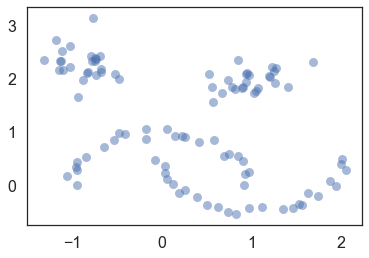

In [7]:
# generate data
moons, _ = data.make_moons(n_samples=50, 
                           noise=0.05)

blobs, _ = data.make_blobs(n_samples=50, 
                           centers=[(-0.75,2.25), (1.0, 2.0)], 
                           cluster_std=0.25)

test_data = np.vstack([moons, blobs])

plt.scatter(test_data.T[0], 
            test_data.T[1], 
            color='b', 
            **plot_kwds)

In [9]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(test_data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

- Transform the space according to the density/sparsity.
- Build the minimum spanning tree of the distance weighted graph.
- Construct a cluster hierarchy of connected components.
- Condense the cluster hierarchy based on minimum cluster size.
- Extract the stable clusters from the condensed tree.

#### Transform the space 
To find clusters we want to find the islands of higher density amid a sea of sparser noise – 
- and the assumption of noise is important
- real data is messy and has outliers, corrupt data, and noise. 

The core of the clustering algorithm is __single linkage__ clustering, and it can be quite sensitive to noise: a single noise data point in the wrong place can act as a bridge between islands, gluing them together. 

Obviously we want our algorithm to be robust against noise so we need to find a way to help ‘lower the sea level’ before running a single linkage algorithm.

#### How can we characterize ‘sea’ and ‘land’ without doing a clustering?

- As long as we can get an estimate of density we can consider lower density points as the ‘sea’. 

- The goal here is __not to perfectly distinguish__ ‘sea’ from ‘land’ – this is an initial step in clustering, not the ouput – just to make our clustering core a little more robust to noise. 

- So given an identification of ‘sea’ we want to lower the sea level. For practical purposes that means making ‘sea’ points more distant from each other and from the ‘land’.